In [53]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [67]:
# Parameters
BATCH_SIZE = 64
IMG_SIZE = 300
DROP_OUT_RATE = 0.4
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
DECAY_RATE = 0.98

In [55]:
if torch.cuda.is_available():
    print(":)")
else:
    print(":(")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

:)


In [57]:
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Normalize(0, 1)
])

In [58]:
trainset = datasets.ImageFolder('/dtu/datasets1/02514/hotdog_nothotdog/train', transform=transformations)
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testset = datasets.ImageFolder('/dtu/datasets1/02514/hotdog_nothotdog/test', transform=transformations)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

In [59]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.nonLinearActivation = nn.LeakyReLU
        self.dropoutRate = DROP_OUT_RATE
        conv_output_size = int(IMG_SIZE/4)
        
        self.convolutional = nn.Sequential(
                nn.BatchNorm2d(3),
                nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same'),
                nn.Dropout(self.dropoutRate),
                self.nonLinearActivation(),
                nn.BatchNorm2d(32),
                nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same'),
                nn.Dropout(self.dropoutRate),
                self.nonLinearActivation(),
                nn.MaxPool2d(kernel_size=2),
                nn.BatchNorm2d(32),
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),
                nn.Dropout(self.dropoutRate),
                self.nonLinearActivation(),
                nn.BatchNorm2d(64),
                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
                nn.Dropout(self.dropoutRate),
                self.nonLinearActivation(),
                nn.MaxPool2d(kernel_size=2),
                nn.BatchNorm2d(64)
                )
    
        self.fully_connected = nn.Sequential(
                nn.Linear(conv_output_size*conv_output_size*64, 500),
                nn.Dropout(self.dropoutRate),
                self.nonLinearActivation(),
                nn.BatchNorm1d(500),
                nn.Linear(500, 10))
#                 nn.Softmax(dim=1))    
    
    def forward(self, x):
        x = self.convolutional(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [60]:
def train(model, optimizer, num_epochs=NUM_EPOCHS, lr_scheduler=None):
    
    def loss_fun(output, target):
        return F.cross_entropy(output, target)
    
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()
            
            if lr_scheduler is not None:
                lr_scheduler.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
            
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
            
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
        
    return out_dict

In [68]:
model = Network()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=DECAY_RATE)

out_dict_sgd = train(model, optimizer)#, lr_scheduler=lr_scheduler)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 1.561	 test: 5.945	 Accuracy train: 70.1%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 1.053	 test: 2.987	 Accuracy train: 78.3%	 test: 48.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.792	 test: 1.530	 Accuracy train: 79.9%	 test: 68.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.556	 test: 1.354	 Accuracy train: 84.6%	 test: 59.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.372	 test: 1.073	 Accuracy train: 88.9%	 test: 68.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.259	 test: 0.743	 Accuracy train: 91.4%	 test: 66.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.167	 test: 0.688	 Accuracy train: 94.4%	 test: 73.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.115	 test: 0.637	 Accuracy train: 96.6%	 test: 74.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.069	 test: 0.811	 Accuracy train: 98.0%	 test: 67.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.053	 test: 0.654	 Accuracy train: 98.7%	 test: 69.5%


In [ ]:
# Basic - 65.9%
# With scheduler - 54%
# After adding batch norm at the begining - 64.6%
# After normalizing input - 68.2%
# Back to scheduler 0.9/0.98 - 48.1%/48.7%
# Increased dropout to 0.4 - 69.5%

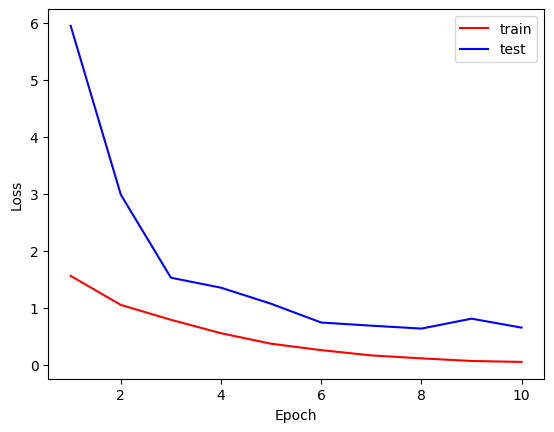

In [69]:
plt.plot([e for e in range(1, NUM_EPOCHS+1)], out_dict_sgd['train_loss'], c='r', label='train')
plt.plot([e for e in range(1, NUM_EPOCHS+1)], out_dict_sgd['test_loss'], c='b', label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()